In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils

import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML
import finbox

In [2]:
country = 'USA'
prediction_location = os.path.join(os.getcwd(), 'cache')

with open(os.path.join(prediction_location, '%s_preds_t120_p12.pickle' % country), 'rb') as f:
    preds = pickle.load(f)

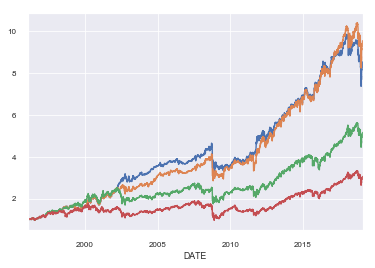

In [3]:
(preds['returns_0.0'] + 1).cumprod().plot()
(preds['returns_0.3'] + 1).cumprod().plot()
(preds['returns_0.5'] + 1).cumprod().plot()
(preds['returns_0.7'] + 1).cumprod().plot()

In [4]:
weights = utils.reverse_labels_to_weights(country, preds['preds'], 
                                          preds['probla'],
                                          preds['labels'],
                                          0.)
assets = utils.construct_virtual_assets(country)

## Performance Without Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.61,2008-09-17,2008-10-27,2011-10-06,797
1,24.24,2017-12-28,2018-12-25,NaT,NaN
2,20.97,2000-09-01,2000-12-20,2001-03-20,143
3,16.22,1999-04-08,1999-08-02,2000-02-29,234
4,13.57,2001-04-04,2001-04-20,2002-02-04,219


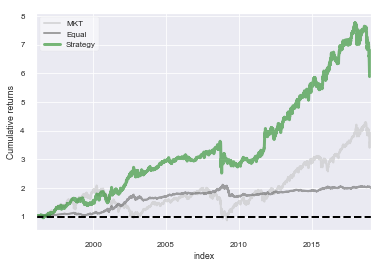

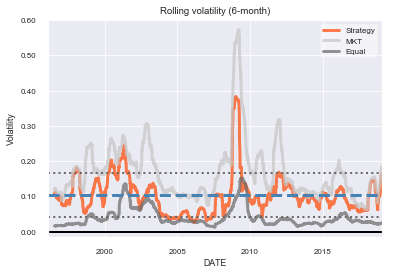

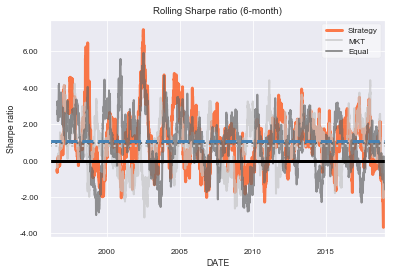

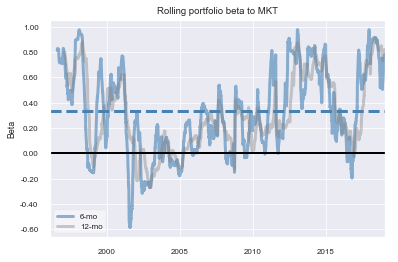

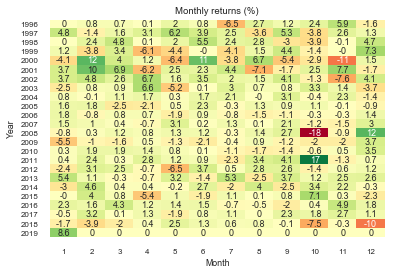

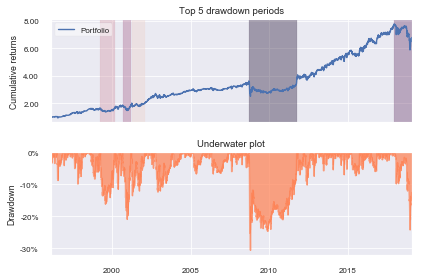

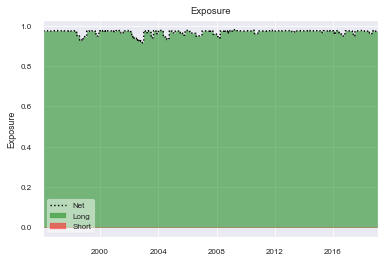

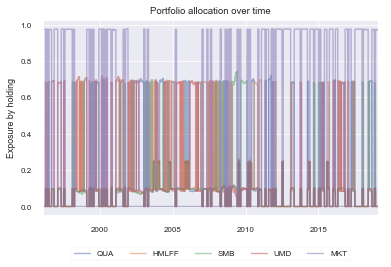

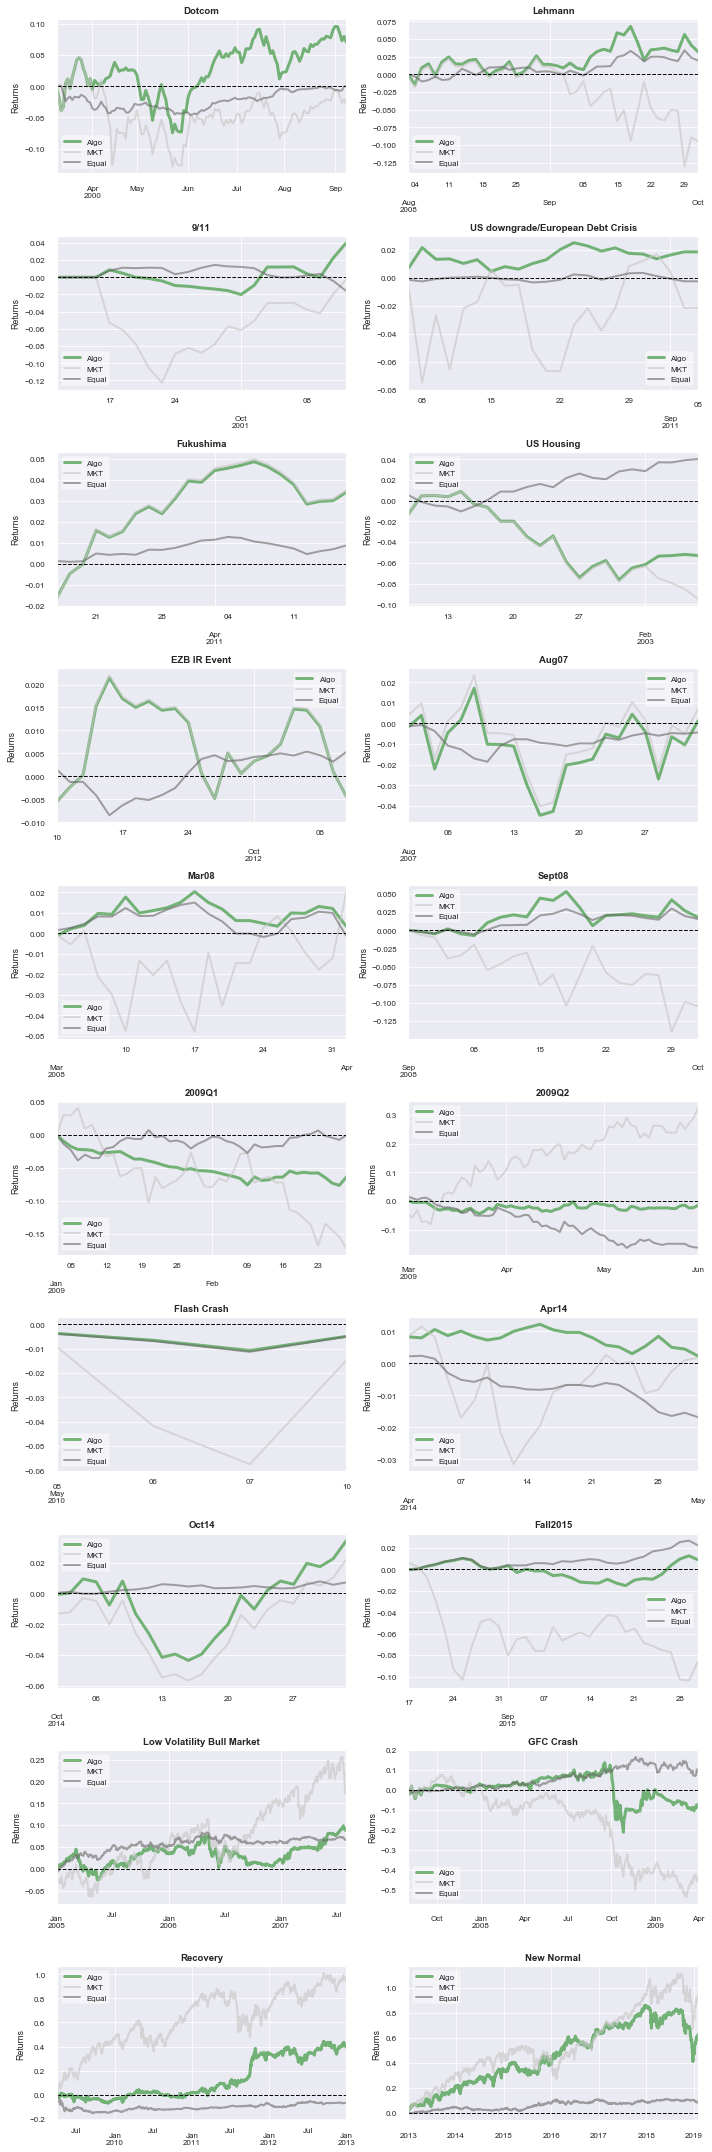

In [5]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_clean = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance With Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.55,2002-10-09,2008-10-27,2013-05-15,2766
1,26.98,2017-12-28,2018-12-25,NaT,NaN
2,23.62,1998-08-31,2000-12-20,2001-04-03,677
3,14.75,2001-04-04,2001-10-01,2002-03-27,256
4,10.21,2015-03-02,2015-09-18,2016-03-17,274


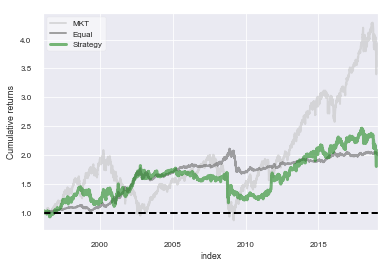

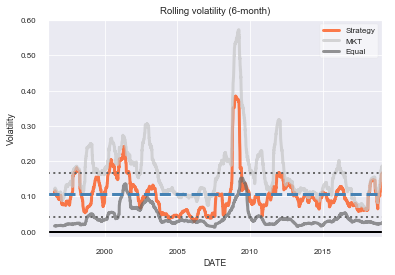

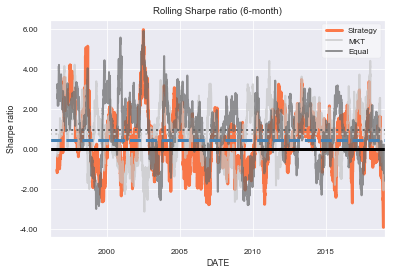

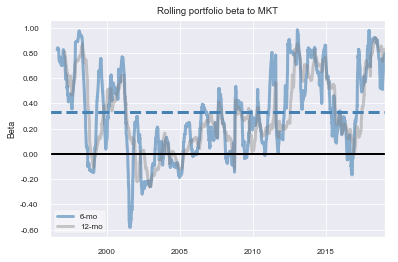

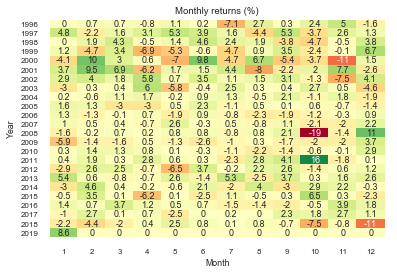

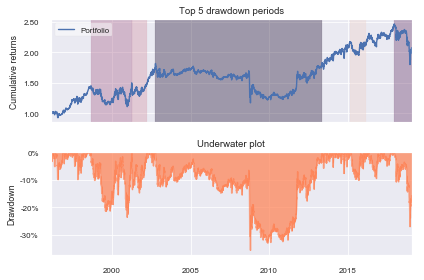

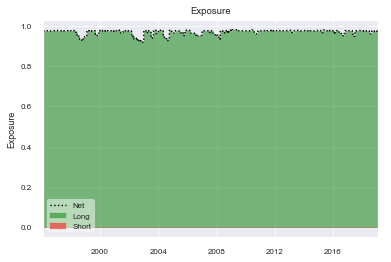

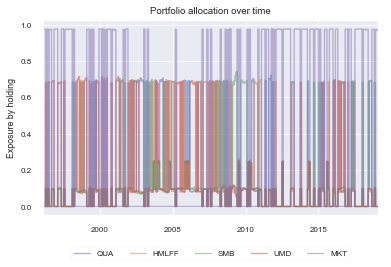

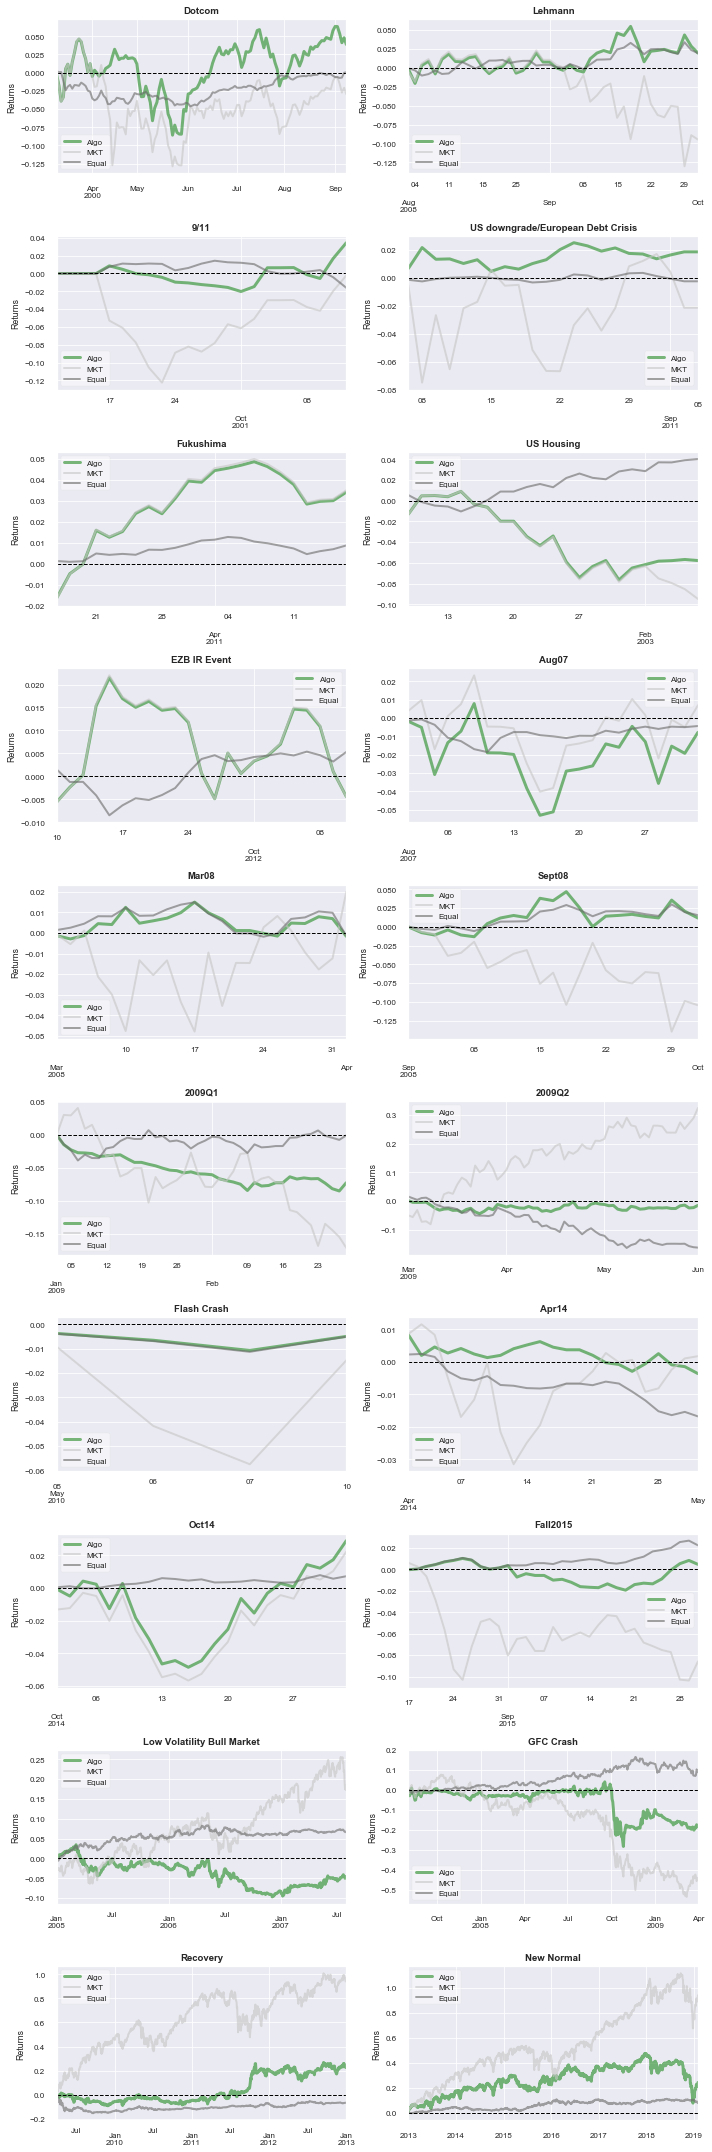

In [6]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    commission_settings=[
        {'commission': 0.01, 'name': 'UMD'},
        {'commission': 0.0035, 'name': 'HMLFF'},
        {'commission': 0.0035, 'name': 'SMB'},
        {'commission': 0.005, 'name': 'QUA'},
        {'commission': 0.001, 'name': 'MKT'}
    ],  # applied 0.1% transaction costs for each trade
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_costs = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance Comparison

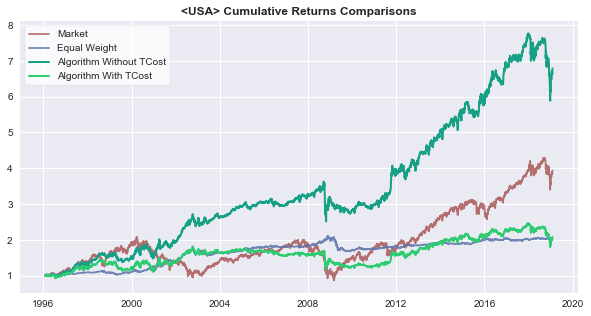

In [22]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.plot((benchmark1 + 1).cumprod(), label='Market', color=utils.COLOR_MAPPER['MKT'], alpha=.85)
ax.plot((benchmark2 + 1).cumprod(), label='Equal Weight', alpha=.85, color=utils.COLOR_MAPPER['equal'])
ax.plot((returns_clean + 1).cumprod(), label='Algorithm Without TCost', color='#16A085', lw=2)
ax.plot((returns_costs + 1).cumprod(), label='Algorithm With TCost', color='#2ECC71', lw=2)
ax.set_title('<%s> Cumulative Returns Comparisons' % country, fontsize=12, fontweight=700)

ax.legend()
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots',
                                         'ML_Others', '%s_oos_perf.pdf' % country)), bbox_inches='tight')

## Feature Importances

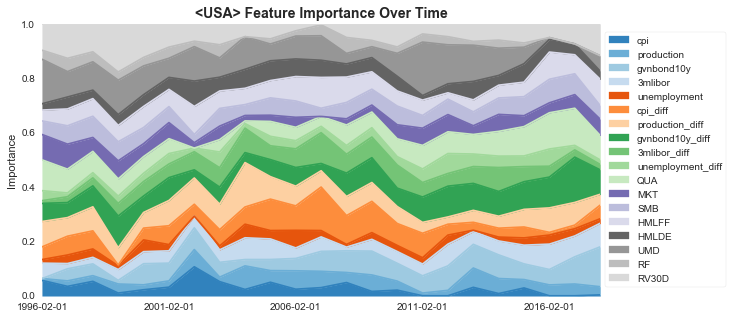

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('<%s> Feature Importance Over Time' % country,
             fontsize=14, fontweight=700)
utils.plot_feature_importance_over_time(preds['models'],
                                        utils.FeatureBuilder().get_features().columns.tolist(),
                                        ax)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_importance.pdf' % country)), bbox_inches='tight')

## Weights Shifts

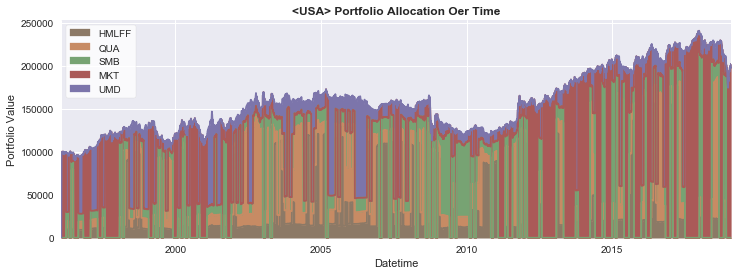

In [24]:
factors = ['HMLFF', 'QUA', 'SMB', 'MKT', 'UMD']
colors=[utils.COLOR_MAPPER[factor] for factor in factors]
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = rb.positions[factors].plot.area(figsize=(12, 4), color=colors)
    ax.set_ylabel('Portfolio Value')
    ax.set_title('<%s> Portfolio Allocation Oer Time' % country,
             fontsize=12, fontweight=700)
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_weights.pdf' % country)), bbox_inches='tight')

## Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
aqr = utils.load_aqr_data(country).dropna()
portfolios = utils.build_portfolio(aqr, main_weights=[0.7],
                                   prefix_names=['main'],
                                   include_mkt=True)
rf = aqr['RF'].dropna()
mkt = aqr['MKT'].dropna()
po = utils.PortfolioOptimizer(portfolios=portfolios,
                              riskfree=rf,
                              market=mkt,
                              country=country)

po.get_stats_table()
po.get_best_indicators()

y_true, true_labels = po.get_labels()

# y_pred = preds['preds'].dropna().astype(int).values.flatten()
# y_true = y_true.loc[preds['preds'].dropna().index].astype(int).values.flatten()

y_pred = preds['preds'].dropna()
y_true = y_true.loc[y_pred.index]
for i, label in enumerate(true_labels):
    y_pred = y_pred.replace(i, label)
    y_true = y_true.replace(i, label)

Normalized confusion matrix
[[0.42857143 0.05714286 0.14285714 0.17142857 0.1        0.1       ]
 [0.55       0.         0.1        0.2        0.05       0.1       ]
 [0.32432432 0.05405405 0.08108108 0.13513514 0.02702703 0.37837838]
 [0.33928571 0.03571429 0.07142857 0.25       0.14285714 0.16071429]
 [0.46666667 0.04444444 0.11111111 0.11111111 0.13333333 0.13333333]
 [0.33333333 0.02083333 0.16666667 0.14583333 0.0625     0.27083333]]


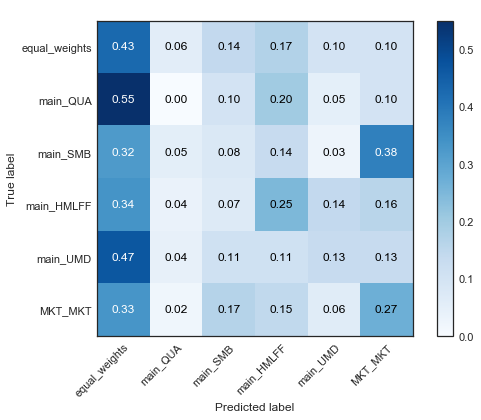

In [12]:
import matplotlib as mpl
mpl.style.use('seaborn-white')

fig, ax = plt.subplots(1,1,figsize=(8,6))
plot_confusion_matrix(y_true, y_pred, classes=true_labels, normalize=True, title=' ', ax=ax)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_cm.pdf' % country)), bbox_inches='tight')

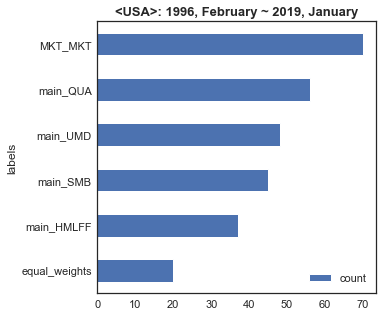

In [14]:
y_true['count'] = 1
fig, ax = plt.subplots(1,1,figsize=(5,5))
y_true.groupby('labels').sum().sort_values(by='count').plot.barh(ax=ax)
ax.set_title('<%s>: %s ~ %s' % (country, y_true.index[0].strftime('%Y, %B'),
                                y_true.index[-1].strftime('%Y, %B')), fontweight=700, fontsize=13)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_oos_dist.pdf' % country)), bbox_inches='tight')